# Cox regression and hazard ratio model

Cox fa analisi di ogni variabile data e predice per ognuna l'hazard ratio, ovvero una probabilità, che se >1 indica che il rischio dell'accadere dell'evento aumenta all'aumentare del valore di quella variabile (o presenza di quella variabile in caso di booleane), mentre diminuisce se l'hazard ratio è <1. 


Input : feature vectors con età del paziente alla diagnosi, last days to follow-up, evento morte booleano, miRNA-seq vector con valori normalizzati con log e quantile.

Pipeline:
   - Scaling con **Z-scaler** su campi di età e miRNA-seq
   - Applicazione di elsatic net tramite ```scikit-survival.CoxnetSurvivalAnalysis``` da addestrare (scikit-survival at: https://scikit-survival.readthedocs.io/en/stable/user_guide/coxnet.html)
      - Applicare grid search e K-fold cross validation per capire set di parametri migliori
   - Calcolo di risk score con funzione di predict
        - possibile prevedere survival function o cumulative hazard function anche, ma necessario fare fine tuning con parametro ```fit_baselin_model=True```

Motivazioni:
   - Z-scaler per portare valori predittivi su stessa scala con varianza 1 e media 0
   - Utilizzo di Cox con penalizzazione per fare feature selection e selezionare solo miRNA con maggiore rilevanza
   - Utilizzo Elastic Net poichè Lasso-Cox normale non ottimale per due motivi: non può selezionare più features di quanti sample ci sono e in gruppo di features con alta correlazione tra loro ne sceglie a caso solo una tra queste. Elastic net risolve questi usando combinazione di l1 e l2 e rendendo più robusto

## Init

In [1]:
%matplotlib inline

In [11]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [12]:
base = os.path.basename(os.getcwd())
list = os.getcwd().split(os.sep) 
list.pop(list.index(base))
ROOT = '\\'.join(list)
print(ROOT)
DATA_PATH = os.path.join(ROOT, 'datasets\\preprocessed')

SEED = 42

d:\Universita\2 anno magistrale\Progetto BioInf\miRNA_to_age


In [13]:
dataset = pd.read_csv(os.path.join(DATA_PATH, 'clinical_miRNA_normalized_log.csv'))

In [14]:
print(dataset.shape)
print(dataset.columns)
# print(dataset.head())
print(type(dataset.iloc[0]['days_to_death']))

(760, 1896)
Index(['days_to_death', 'age_at_initial_pathologic_diagnosis',
       'days_to_last_followup', 'Death', 'pathologic_stage_Stage I',
       'pathologic_stage_Stage IA', 'pathologic_stage_Stage IB',
       'pathologic_stage_Stage II', 'pathologic_stage_Stage IIA',
       'pathologic_stage_Stage IIB',
       ...
       'hsa-mir-941-5', 'hsa-mir-942', 'hsa-mir-943', 'hsa-mir-944',
       'hsa-mir-95', 'hsa-mir-9500', 'hsa-mir-96', 'hsa-mir-98', 'hsa-mir-99a',
       'hsa-mir-99b'],
      dtype='object', length=1896)
<class 'numpy.float64'>


## Hyper-parameters

In [15]:
num_folds = 20

## Data

In [16]:
unique, count = np.unique(dataset['age_at_initial_pathologic_diagnosis'], return_counts=True)
to_drop = [unique[u] for u in range(len(unique)) if count[u] < 5]
print(to_drop)
print(dataset.shape)

dataset=dataset[~dataset['age_at_initial_pathologic_diagnosis'].isin(to_drop)]
print(dataset.shape)

[np.int64(26), np.int64(27), np.int64(30), np.int64(31), np.int64(32), np.int64(83), np.int64(85), np.int64(86), np.int64(88), np.int64(89)]
(760, 1896)
(739, 1896)


In [17]:
y_cols = ['Death', 'days_to_death', 'days_to_last_followup']
X_cols = [col for col in dataset.columns if col not in y_cols]

custom_dtype = np.dtype([
    ('death', np.bool_),         # O 'bool'
    ('days', np.float64)      # O 'float'
])

y = []
for index,row in dataset[y_cols].iterrows():
    if row['Death'] == 1:
        y.append(np.array((True, row['days_to_death'].item()), dtype=custom_dtype))
    elif row['Death'] == 0:
        tuple = (False, row['days_to_last_followup'].item())
        y.append(np.array(tuple, dtype=custom_dtype)) 
y = np.array(y)

X = dataset[X_cols]
# remove columns with zero-variance
# print(X.shape)
X = X.loc[:, X.var() != 0]
# print(X.shape)


## Z-scaling

In [18]:
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# minmax = MinMaxScaler(feature_range=(0,15))

scaled_X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
# minmaxed_X = pd.DataFrame(minmax.fit_transform(scaled_X), columns = scaled_X.columns)

## Data splitting

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)

## K-fold

In [20]:
from sklearn.model_selection import KFold, StratifiedKFold

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)
# kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)

## Linear MLP

### 3-layer model

In [24]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, accuracy_score, r2_score

class MiRNANet_3(nn.Module):
    def __init__(self, input_dim, output_dim, dropout, start_lr=0.001, lr_decay=0.3, patience=15):
        super(MiRNANet_3, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, output_dim),
            nn.Softmax(-1)
        )
        self.lr_decay = lr_decay
        self.patience = patience
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=start_lr)
        self.criterion = nn.L1Loss()
        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode='min',        # riduce LR quando la metrica (loss) smette di diminuire
            factor=self.lr_decay,        # dimezza il learning rate
            patience=self.patience        # aspetta 10 epoche senza miglioramenti
        )
    def forward(self, x):
        return self.model(x)   
    def loop(self, train_loader, test_loader, epochs=100):
        train_losses = []
        val_losses = []
        train_accs = []
        val_accs = []
        for epoch in range(epochs):
            self.model.train()
            total_train_loss = 0
            total_train_acc = 0
            for X_batch, y_batch in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()
                total_train_loss += loss.item()
                total_train_acc += accuracy_score(np.argmax(outputs.detach().numpy(), axis=1), np.argmax(y_batch, axis=1))
            
            avg_train_loss = total_train_loss / len(train_loader)
            avg_train_acc = total_train_acc / len(train_loader)
            
            self.scheduler.step(avg_train_loss)

            train_accs.append(avg_train_acc)

            self.model.eval()
            total_val_loss = 0
            total_val_acc = 0
            with torch.no_grad():
                preds = []
                trues = []
                for X_batch, y_batch in test_loader:
                    outputs = self.model(X_batch)
                    loss = self.criterion(outputs, y_batch)
                    preds.append(outputs.numpy())
                    trues.append(y_batch.numpy())
                    total_val_loss += loss.item()
                    total_val_acc += accuracy_score(np.argmax(outputs.detach().numpy(), axis=1), np.argmax(y_batch, axis=1))
                preds = np.vstack(preds)
                trues = np.vstack(trues)
            avg_val_loss = total_val_loss / len(test_loader)
            avg_val_acc = total_val_acc / len(test_loader)

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            val_accs.append(avg_val_acc)

            print(f"Epoch {epoch+1:03d}:\nTrain Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}\nTrain Acc: {avg_train_acc:.4f} | Val Acc: {avg_val_acc:.4f}")
            mae = mean_absolute_error(trues, preds)
            print(f"Test MAE: {mae:.2f}")

        model_res = {
            'params':self.model.parameters(),
            'train_losses':train_losses,
            'eval_losses': val_losses,
            'train_accs': train_accs,
            'val_accs':val_accs,
            'preds':preds,
            'trues':trues
        }

        return model_res

### 5-layer model

In [25]:
class MiRNANet_5(nn.Module):
    def __init__(self, input_dim, output_dim, dropout, start_lr = 0.001):
        super(MiRNANet_5, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, output_dim)  # <--- ultimo layer lineare
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=start_lr)
        self.criterion = nn.MSELoss()
        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode='min',        # riduce LR quando la metrica (loss) smette di diminuire
            factor=0.6,        # dimezza il learning rate
            patience=15        # aspetta 10 epoche senza miglioramenti
        )
    def forward(self, x):
        return self.model(x)
    
    def loop(self, train_loader, test_loader, epochs=100):
        train_losses = []
        val_losses = []
        for epoch in range(epochs):
            self.model.train()
            total_train_loss = 0
            for X_batch, y_batch in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(X_batch)
                # print(outputs)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()
                total_train_loss += loss.item()
            
            avg_train_loss = total_train_loss / len(train_loader)
            self.scheduler.step(avg_train_loss)

            self.model.eval()
            total_val_loss = 0
            with torch.no_grad():
                preds = []
                trues = []
                for X_batch, y_batch in test_loader:
                    outputs = self.model(X_batch)
                    loss = self.criterion(outputs, y_batch)
                    preds.append(outputs.numpy())
                    trues.append(y_batch.numpy())
                preds = np.vstack(preds)
                trues = np.vstack(trues)
                total_val_loss += loss.item()
            avg_val_loss = total_val_loss / len(test_loader)

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        model_res = {
            'params':self.model.parameters(),
            'train_losses':train_losses,
            'eval_losses': val_losses
        }

        return model_res

### Data format correction

In [26]:
import torch

y_train_fixed = np.array([(row['death'], row['days']) for row in y_train], dtype=[('death', np.bool_), ('days', np.float64)])
y_test_fixed = np.array([(row['death'], row['days']) for row in y_test], dtype=[('death', np.bool_), ('days', np.float64)])

X_train_mlp = torch.tensor(X_train.values, dtype=torch.float32)
X_test_mlp = torch.tensor(X_train.values, dtype=torch.float32)
y_train_mlp = torch.tensor([row for row in y_train_fixed], dtype=torch.float32)
y_test_mlp = torch.tensor([row for row in y_test_fixed], dtype=torch.float32)

### Grid search for best parameters

In [ ]:
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
from skorch.callbacks import LRScheduler


# GRID SEARCH
net = NeuralNetRegressor(
    module=MiRNANet_3,
    module__input_dim=X_train_mlp.shape[1],
    module__output_dim=y_train_mlp.shape[1],
    max_epochs=60,
    lr=1e-3,
    batch_size=32,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-5,
    optimizer__lr=0.001,
    criterion=nn.L1Loss(),
    callbacks=[
         ('lr_scheduler', LRScheduler(
             ReduceLROnPlateau, 
             mode='min', 
             factor=0.7, 
             patience=15, 
             monitor='valid_loss',
             min_lr=1e-6
         ))
    ],
)

params = {
    #'module__hidden1': [128, 256, 512],
    #'module__hidden2': [64, 128, 256],
    'module__dropout': [0.2, 0.3, 0.5],
    'module__start_lr': [1e-3, 1e-4],
    #'module__lr_decay': [0.3, 0.4],
    #'optimizer__weight_decay': [0, 1e-5, 1e-4],
    #'callbacks__lr_scheduler__factor': [0.8, 0.6, 0.4],
    #'callbacks__lr_scheduler__patience': [15, 10, 5],
    'lr': [1e-1, 5e-4]
}

gs = GridSearchCV(net, 
                  params, 
                  refit=True, 
                  cv=kfold,  # cross-validation folds 
                  scoring='neg_mean_squared_error', 
                  verbose=1)
gs.fit(X_train_mlp, y_train_mlp)

best_model = gs.best_estimator_
print("Best hyperparameters:", gs.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      368.6932      441.1831  0.0010  0.1078
      2      368.5039      441.0685  0.0010  0.1167
      3      368.4366      441.0355  0.0010  0.1131
      4      368.4205      441.0250  0.0010  0.1193
      5      368.4160      441.0207  0.0010  0.1057
      6      368.4152      441.0184  0.0010  0.1133
      7      368.4145      441.0170  0.0010  0.0839
      8      368.4143      441.0161  0.0010  0.0776
      9      368.4140      441.0154  0.0010  0.0999
     10      368.4140      441.0146  0.0010  0.0980
     11      368.4135      441.0140  0.0010  0.0871
     12      368.4134      441.0137  0.0010  0.0988
     13      368.4134      441.0133  0.0010  0.0767
     14      368.4135      441.0130  0.0010  0.0810
     15      368.4133      441.0127  0.0010  0.1039
     16      368.4132      441.0125  0.0010  0.0980
 

In [ ]:
preds = best_model.predict(X_test_mlp)
mae = mean_absolute_error(y_test_mlp, preds)
r2 = r2_score(y_test_mlp, preds)
print(f"Test MAE: {mae:.2f} | R2: {r2:.2f}")

## Elastic net (Lasso-Cox)

### Resulting coefficients for different penalty scores alphas

In [ ]:
from sksurv.linear_model import CoxnetSurvivalAnalysis

alphas = 10.0 ** np.linspace(-2, 2, 20)
coefficients = {}

print(alphas)

cph = CoxnetSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(X_train, y_train)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_
    print(f"Finished fitting for alpha coefficient : {alpha}")

coefficients = pd.DataFrame.from_dict(coefficients).rename_axis(index="feature", columns="alpha").set_index(X.columns)
# coefficients.to_csv(os.path.join(DATA_PATH, 'Cox_coefficients.csv'), index=False)

[1.00000000e-02 1.62377674e-02 2.63665090e-02 4.28133240e-02
 6.95192796e-02 1.12883789e-01 1.83298071e-01 2.97635144e-01
 4.83293024e-01 7.84759970e-01 1.27427499e+00 2.06913808e+00
 3.35981829e+00 5.45559478e+00 8.85866790e+00 1.43844989e+01
 2.33572147e+01 3.79269019e+01 6.15848211e+01 1.00000000e+02]


c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:200: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])
c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:197: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])


Finished fitting for alpha coefficient : 0.01


c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:200: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])
c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:197: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])


Finished fitting for alpha coefficient : 0.016237767391887217


c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:200: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])
c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:197: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])


Finished fitting for alpha coefficient : 0.026366508987303583


c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:200: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])
c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:197: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])


Finished fitting for alpha coefficient : 0.04281332398719394


c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:200: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])
c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:197: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])


Finished fitting for alpha coefficient : 0.06951927961775606


c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:200: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])
c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:197: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])


Finished fitting for alpha coefficient : 0.11288378916846889


c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:197: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:200: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])


Finished fitting for alpha coefficient : 0.18329807108324356


c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:197: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:200: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])


Finished fitting for alpha coefficient : 0.29763514416313175


c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:197: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:200: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])


Finished fitting for alpha coefficient : 0.4832930238571752


c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:197: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])


Finished fitting for alpha coefficient : 0.7847599703514611


c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:197: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])


Finished fitting for alpha coefficient : 1.2742749857031335


c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:197: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])


Finished fitting for alpha coefficient : 2.06913808111479
Finished fitting for alpha coefficient : 3.359818286283781
Finished fitting for alpha coefficient : 5.455594781168514
Finished fitting for alpha coefficient : 8.858667904100823
Finished fitting for alpha coefficient : 14.38449888287663
Finished fitting for alpha coefficient : 23.357214690901213
Finished fitting for alpha coefficient : 37.92690190732246
Finished fitting for alpha coefficient : 61.584821106602604
Finished fitting for alpha coefficient : 100.0


### Coefficient plotting

In [86]:
def plot_coefficients(coefs):
    _, ax = plt.subplots(figsize=(9, 6))
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    ax.yaxis.set_label_position("left")
    ax.yaxis.tick_left()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")
    ax.legend(loc='best')

### Fit of Cox Elastic Net

In [116]:
from sklearn.model_selection import cross_val_score
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

def c_index_scorer(estimator, X, y):
    # Estrai i campi 'death' e 'days' da y
    event_indicator = y['death']
    event_time = y['days']
    # Predici i punteggi di rischio
    risk_scores = estimator.predict(X)
    # Calcola il concordance index
    c_index = concordance_index_censored(event_indicator, event_time, risk_scores)[0]
    return c_index

cen = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
eval_score = cross_val_score(cen, scaled_X, y, cv=kfold, scoring=c_index_scorer)
# estimated_alphas = cen.alphas_


In [94]:
print(eval_score)
print(eval_score.mean())

[0.89285714 0.775      0.38888889 0.62962963 1.         0.76
 0.6875     0.75       0.73255814 0.70491803 0.26388889 0.08333333
 0.45454545 0.66666667 0.36363636 0.37777778 0.4        0.83333333
 0.47826087 0.54545455]
0.5894124533449505


In [120]:
cen = cen.fit(X_train, y_train)
coefficients_elastic_net = pd.DataFrame(
    cen.coef_, index=scaled_X.columns, columns=np.round(cen.alphas_, 5)
)
res = cen.predict(X_test)

In [124]:
print(y_test[:5])
print(res[:5])

[(False, 1288.) (False,  196.) (False, 1172.) (False,  983.)
 (False, 1471.)]
[14.70058257 -4.91265461 -7.09499389 -3.1042719   0.84632499]


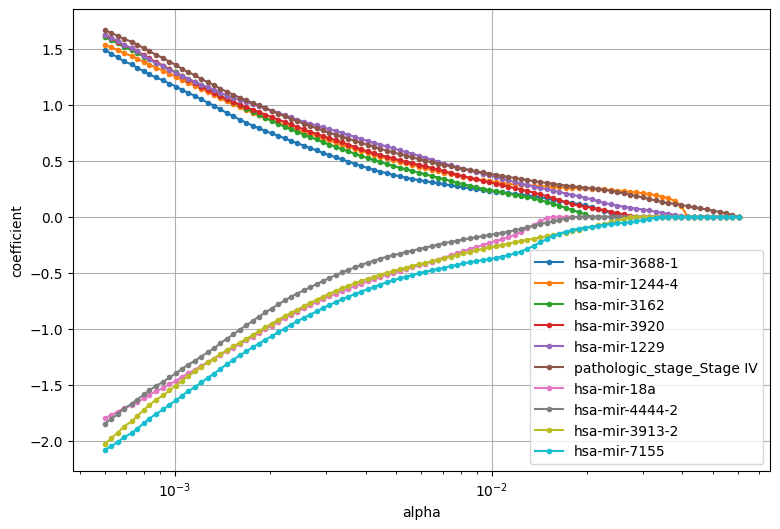

In [87]:
alpha_min = coefficients_elastic_net.columns.min()
n = 10
top_coefs = coefficients_elastic_net.loc[:, alpha_min].map(abs).sort_values().tail(n)

plot_coefficients(coefficients_elastic_net.loc[top_coefs.index])

In [88]:
top_coefs

hsa-mir-3688-1               1.493643
hsa-mir-1244-4               1.539588
hsa-mir-3162                 1.610369
hsa-mir-3920                 1.624499
hsa-mir-1229                 1.628896
pathologic_stage_Stage IV    1.669470
hsa-mir-18a                  1.801252
hsa-mir-4444-2               1.850664
hsa-mir-3913-2               2.031967
hsa-mir-7155                 2.085597
Name: 0.0006, dtype: float64

### Gridsearch for best paramters

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sksurv.linear_model import CoxnetSurvivalAnalysis
import warnings
from sklearn.exceptions import FitFailedWarning

cen = make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01))

warnings.simplefilter("ignore", UserWarning)
# warnings.simplefilter("ignore", FitFailedWarning)

cen.fit(X_train, y_train)
estimated_alphas = cen.named_steps["coxnetsurvivalanalysis"].alphas_

gcv = GridSearchCV(
    make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in map(float, estimated_alphas)]},
    cv=kfold,
    error_score=0.5,
    n_jobs=1,
).fit(X_train, y_train)

cv_results = pd.DataFrame(gcv.cv_results_)

In [ ]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)